In [15]:
import pandas as pd
import numpy as np
import pickle
from FPMC import FPMC as FM
import dill
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

%matplotlib inline

In [10]:
fName = 'tesModel3.pcl'
obj = FM()
obj.load(fName)

In [3]:
# import products description
products    =  pd.read_csv('../data/products.csv',index_col='product_id')

In [4]:
orders = pd.read_csv('../data/orders.csv',index_col = 'order_id',
                     usecols = ['order_id','user_id','eval_set','order_number','days_since_prior_order'])

usecols = ['order_id','product_id']
items = pd.concat([pd.read_csv('../data/order_products__train.csv',usecols = usecols),
                   pd.read_csv('../data/order_products__prior.csv',usecols = usecols)])

/home/frodos/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
def testModel(tUser):
    tOrders = orders.query('user_id == @tUser')
    testOrder = tOrders.query("eval_set != 'prior'")

    if testOrder.eval_set.values == 'test':
        print 'Test user'
        return
    else:
        testOrderId = testOrder.index.values

    # train the model
    prevOrderId = tOrders.query('order_number == 1').index.values
    prevBasket = items.query('order_id == @prevOrderId').product_id.values

    for newOrderId in tOrders.index.values[1:-1]:
        #print 'Order id is', newOrderId
        newBasket = items.query('order_id == @newOrderId').product_id.values
        obj.addOrder(tUser,newBasket,prevBasket,iterations = 1e4)
        prevBasket = newBasket

    testBasket = items.query('order_id == @testOrderId').product_id.values

    ordIds = tOrders.index.values[:-1]
    fullBasket = items.query('order_id in @ordIds').drop_duplicates('product_id')
    fullBasket = fullBasket.merge(products,left_on='product_id',right_index=True).drop(['aisle_id','department_id'],axis = 1) 

    for k ,v in fullBasket.iterrows():
        fullBasket.loc[k,'prob'] =  obj.getProbability(basket=prevBasket, item=v.product_id, user=tUser)
        fullBasket.loc[k,'wasOrdered'] = v.product_id in testBasket
        
    fullBasket.sort_values('wasOrdered',ascending=True,inplace=True) 
    return [fullBasket, roc_curve(fullBasket.wasOrdered,fullBasket.prob)] 

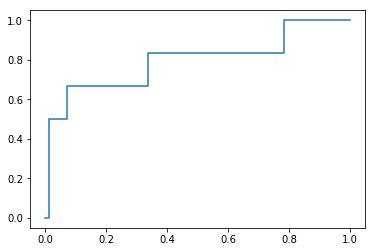

In [38]:
obj.load(fName)
obj.setNormalization(1)
c = testModel(50)
fpr, tpr, thresholds = c[1]
plt.plot(fpr,tpr)

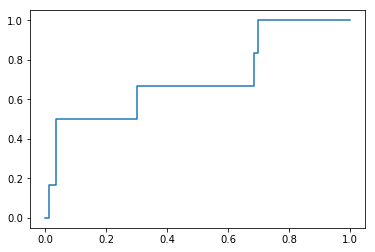

In [39]:
obj.load(fName)
obj.setNormalization(2)
c = testModel(50)
fpr, tpr, thresholds = c[1]
plt.plot(fpr,tpr)

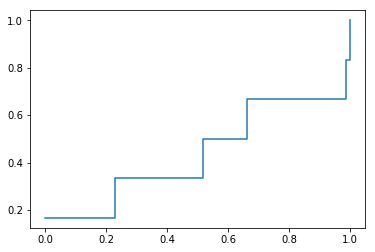

In [40]:
obj.load(fName)
obj.setNormalization(5)
c = testModel(50)
fpr, tpr, thresholds = c[1]
plt.plot(fpr,tpr)

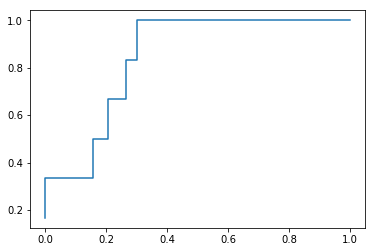

In [41]:
obj.load(fName)
obj.setNormalization(0.1)
c = testModel(50)
fpr, tpr, thresholds = c[1]
plt.plot(fpr,tpr)